In [7]:
#Import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle

# Radomization tests


In this notebook we going show a randomization test using CIFAR10 dataset, the idea is to compare the accuracy of a model with the accuracy of a model with the same architecture but with the labels corrupted, to corrupt the labels we will use a random selection from the CIFAR10 labels. The CIFAR10 dataset has 10 classes, there are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. To execute the random choice is used a probability that indicates the probability of the label be changed- The randomization breaks any relationship between the instance, for example, the image, and the label. We then run the learning algorithm both on the natural data and on the randomized data with identical settings and model choice.(pag 107)


## Corruption of the labels with a percentage

In [8]:
"""
La clase CIFAR10Corrupted es una subclase de CIFAR10 que permite corromper las etiquetas de las imágenes con una probabilidad dada.
"""
class CIFAR10Corrupted(CIFAR10):
    def __init__(self, corrupt_prob, num_classes=10, **kwargs):
        super().__init__(**kwargs)
        if corrupt_prob > 0:
            self.n_classes = num_classes
            self.corrupt_labels(corrupt_prob)

    def corrupt_labels(self, corrupt_prob):
        """
        Dada una probabilidad corrupt_prob, se corrompen las etiquetas de las imágenes con dicha probabilidad.
        """
        labels = np.array(self.targets)
        np.random.seed(42)
        mask = np.random.rand(len(labels)) <= corrupt_prob
        rnd_labels = np.random.choice(self.n_classes, mask.sum())
        labels[mask] = rnd_labels
        labels = [int(x) for x in labels]
        self.targets = labels

To see the effect of the corruption of the labels we will show a batch of images with corrupted using the class `CIFAR10Corrupted` that is a subclass of `torchvision.datasets.CIFAR10` that corrupts the labels with a probability `corruption_prob`.


Files already downloaded and verified


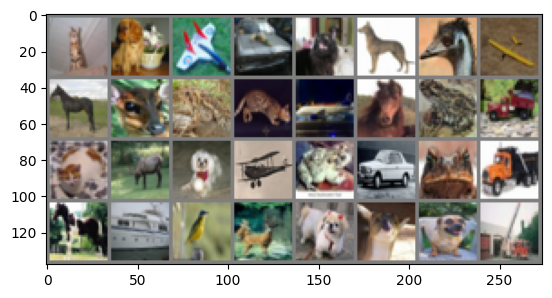

Etiquetas: 
 truck
   dog
 airplane
  frog
 airplane
   dog
  deer
  bird
  frog
  ship
  frog
   cat
 horse
  frog
 automobile
  deer
   cat
 automobile
   dog
 truck
   cat
  ship
 horse
  ship
  ship
 truck
  bird
  frog
 horse
  deer
   cat
 airplane



In [9]:
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

corrupt_prob = 0.8 # Probabilidad de corrupción
batch_size = 32  # Tamaño del lote

# Transformaciones
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Crear el conjunto de datos CIFAR10Corrupted
trainset = CIFAR10Corrupted(root='./CIFAR', train=True, download=True, transform=transform, corrupt_prob=corrupt_prob)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Obtener un lote de imágenes
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Mostrar las imágenes
imshow(torchvision.utils.make_grid(images))
name_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Etiquetas: \n', ' '.join('%5s\n' % name_labels[labels[j]] for j in range(batch_size)))


In [10]:
"""
Esta función devuelve los dataloaders de CIFAR10 con las imágenes corrompidas con una probabilidad dada.
Los dataloaders son los mismos que los de CIFAR10, pero con las etiquetas corrompidas, estos se encargan de cargar los datos en lotes.
"""
def get_cifar_dataloaders_corrupted(corrupt_prob=0, batch_size=32):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = CIFAR10Corrupted(root='./CIFAR', train=True, download=True, transform=transform, corrupt_prob=corrupt_prob)
    print("Trainset: ", trainset)
    train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
    testset = CIFAR10Corrupted(root='./CIFAR', train=False, download=True, transform=transform, corrupt_prob=corrupt_prob)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader



# Inception Neural Network

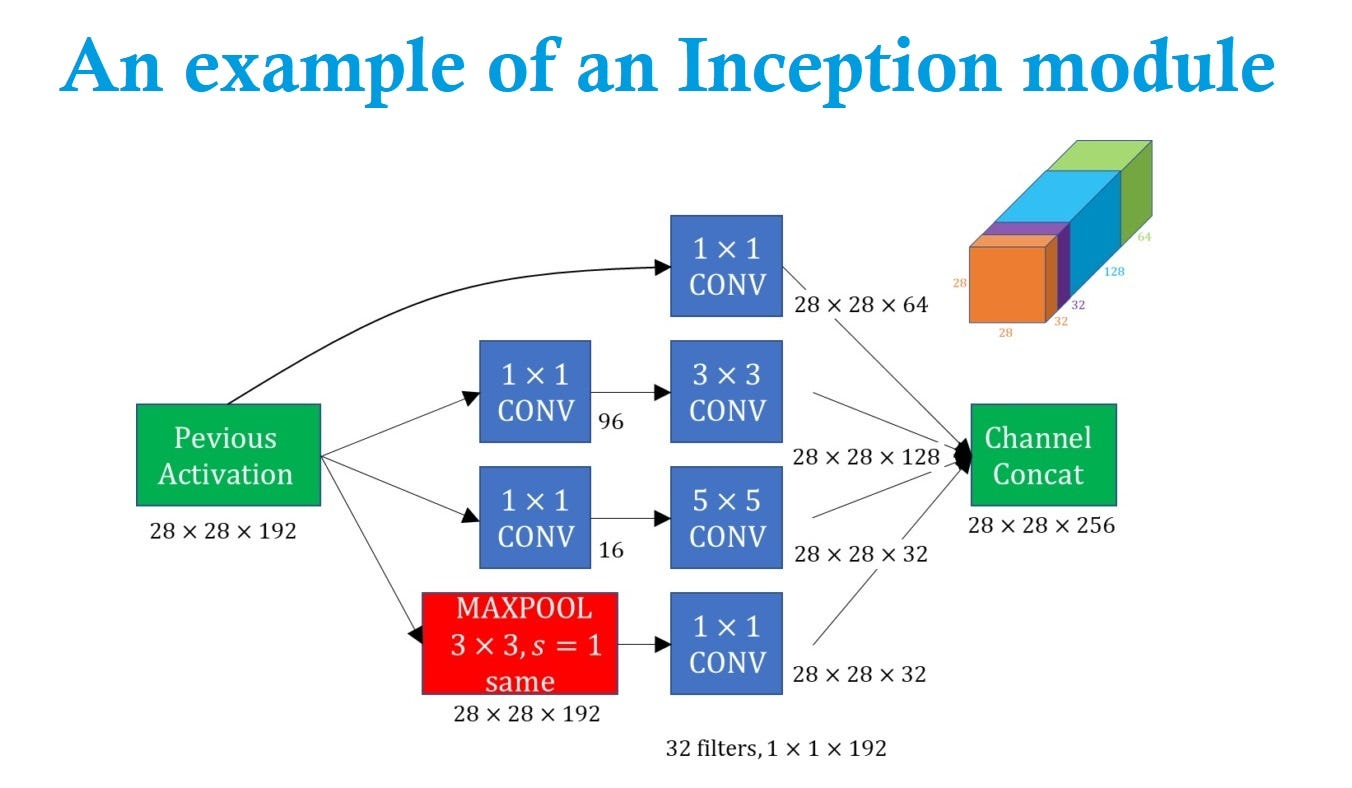

- `in_channels`: Número de canales en la entrada (por ejemplo, 3 para imágenes RGB).
- `out_channels`: Número de canales de salida que produce la convolución.
- `kernel_size`: Tamaño del filtro (por ejemplo, 5 para una convolución 5x5).
- `stride`: Paso de la convolución, es decir, el número de píxeles que se desplaza el filtro en cada paso.
- `padding`: Cantidad de padding (relleno) añadido a los bordes de la entrada.

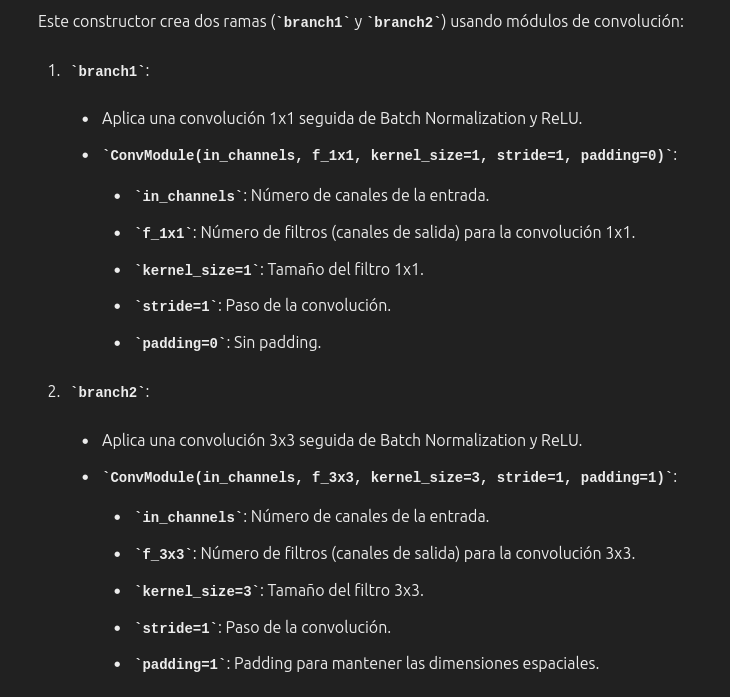

In [11]:
class ConvModule(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
"""
La clase InceptionModule en PyTorch define un módulo que simula el funcionamiento de un módulo de tipo Inception, que es una arquitectura popular en redes neuronales
convolucionales utilizada en modelos como GoogLeNet. Esta arquitectura se basa en la idea de aplicar convoluciones de diferentes tamaños en paralelo y luego
concatenar los resultados.
"""
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionNet(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        
        self.conv1 = ConvModule(in_channels =3,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

# Functions to run the randomization test

In [12]:
def run_train_single_epoch(train_loader, model, device, criterion, optimizer):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*len(inputs)
        if batch_num%200==0:
            print("Batch {} Loss: {}".format(batch_num, loss.item()))
        preds = outputs.argmax(1)
        num_correct += (preds==labels).sum().item()
    epoch_loss = running_loss/len(train_loader.sampler)
    epoch_acc = num_correct/len(train_loader.sampler)
    return epoch_loss, epoch_acc

def run_validation_single_epoch(valid_loader, model, device, criterion):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(valid_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()*len(inputs)
        preds = outputs.argmax(1)
        num_correct += (preds==labels).sum().item()
    epoch_loss = running_loss/len(valid_loader.sampler)
    epoch_acc = num_correct/len(valid_loader.sampler)
    return epoch_loss, epoch_acc

"""
Next, we define the training loop. This function trains the model for a given number of epochs and 
returns the training and validation losses and accuracies.
"""
def training_loop(model, num_epochs, train_loader, valid_loader, device, \
                criterion, optimizer, model_name):
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    highest_acc = 1e-10
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = run_train_single_epoch(train_loader, model, device, criterion, optimizer)
        model.eval()
        valid_loss, valid_acc = run_validation_single_epoch(valid_loader, model, device, criterion)
        print("[Epoch {}] Train Loss: {} Vaidation Loss: {} Train Acc: {} Validation Acc: {}".format(\
              epoch, train_loss, valid_loss, train_acc, valid_acc))
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        if valid_acc > highest_acc:
            torch.save(model.state_dict(), "{}.pth".format(model_name))
            highest_acc = valid_acc
        # else:
        #     print("Early stopping.")
        #     break
    print('Finished Training')
    return train_losses, valid_losses, train_accs, valid_accs

def run_testing(test_loader, model, device):
    model.eval()
    gt_all, preds_all = [], []
    for batch_num, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        gt_all.extend(labels.tolist())
        preds_all.extend(preds.tolist())
    return gt_all, preds_all
    

In [13]:
def plot_losses(training_loss_arr, validation_loss_arr, training_acc_arr, validation_acc_arr, \
                title):
    num_epochs = len(training_loss_arr)
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_loss_arr, '-bo', label="Training Loss")
    ax.plot(range(num_epochs), validation_loss_arr, '-ro', label="Validation Loss")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    plt.subplot(1,2,2)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_acc_arr, '-bo', label="Training Acc")
    ax.plot(range(num_epochs), validation_acc_arr, '-ro', label="Validation Acc")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)    

Declare a dictionary where is the probability of each class be changed, for example, if we want to change the probability of the class 0 be changed we can use the following dictionary:

In [15]:
final_dict = dict()

# Tests varying the corruption probability

## Test for corruption level 0.0: True labels

In [21]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Trainset:  Dataset CIFAR10Corrupted
    Number of datapoints: 50000
    Root location: ./CIFAR
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified
cuda:0


In [22]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [23]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                        device, criterion, optimizer, "InceptionNet_corr_0")

Batch 0 Loss: 2.3285703659057617
Batch 200 Loss: 1.542312741279602
Batch 400 Loss: 1.147411823272705
Batch 600 Loss: 1.2344990968704224
Batch 800 Loss: 1.1229987144470215
Batch 1000 Loss: 0.6849629878997803
Batch 1200 Loss: 0.5097137093544006
Batch 1400 Loss: 0.8826108574867249
[Epoch 0] Train Loss: 1.208939501399994 Vaidation Loss: 0.9438812751770019 Train Acc: 0.58672 Validation Acc: 0.6902
Batch 0 Loss: 0.9316940903663635
Batch 200 Loss: 0.4976913630962372
Batch 400 Loss: 0.554105281829834
Batch 600 Loss: 1.096116542816162
Batch 800 Loss: 1.0295262336730957
Batch 1000 Loss: 0.9855731725692749
Batch 1200 Loss: 0.9082719683647156
Batch 1400 Loss: 0.6007078886032104
[Epoch 1] Train Loss: 0.7295947476100921 Vaidation Loss: 0.7347401600837707 Train Acc: 0.75168 Validation Acc: 0.7537
Batch 0 Loss: 0.48469802737236023
Batch 200 Loss: 0.563144862651825
Batch 400 Loss: 0.676454484462738
Batch 600 Loss: 0.6424193978309631
Batch 800 Loss: 0.9174802899360657
Batch 1000 Loss: 0.7961251139640808

### Graphs results for corruption level 0.0

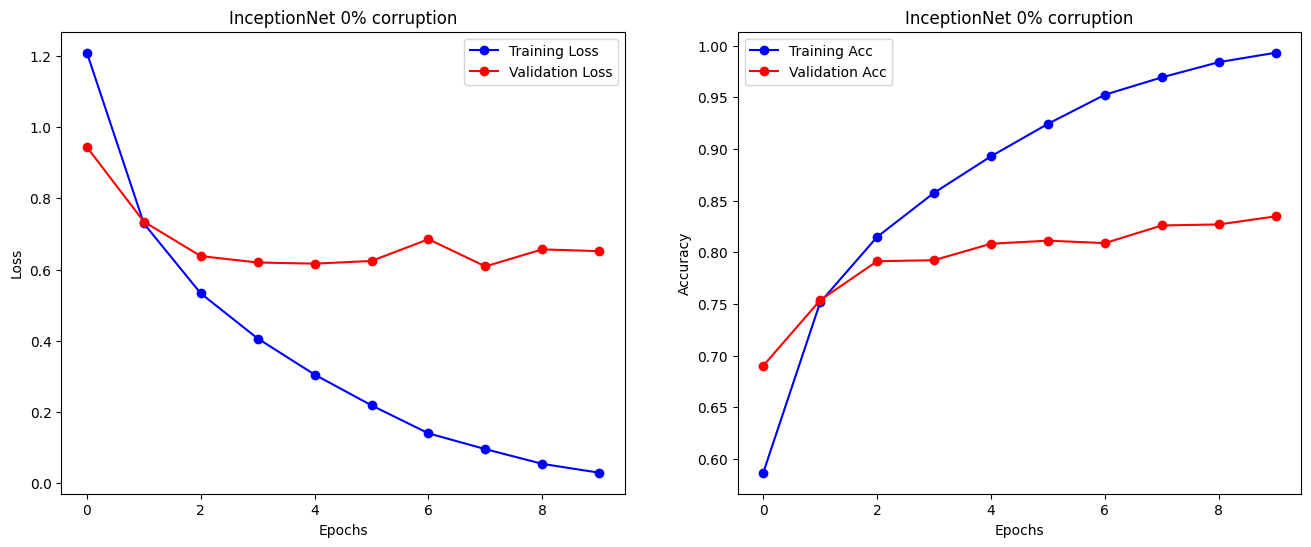

In [24]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 0% corruption")

### Confusion matrix for corruption level 0.0

In [25]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_0.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.8348
Confusion Matrix:
 [[819  11  47  15  14   6   4  12  47  25]
 [ 10 904   0   4   1   5   3   0  14  59]
 [ 40   2 768  43  35  52  39  16   4   1]
 [ 12   2  50 653  23 183  30  22  12  13]
 [  2   0  59  43 785  47  29  29   6   0]
 [  4   0  24  91  20 827  10  20   1   3]
 [  5   0  21  44  12  26 878   3   9   2]
 [ 10   0  16  17  22  52   1 869   2  11]
 [ 25  10   8   5   3   3   3   2 926  15]
 [ 10  33   3   7   0   2   5   5  16 919]]


In [26]:
final_dict[0] = {}
final_dict[0]["train_losses"] = train_losses
final_dict[0]["valid_losses"] = valid_losses
final_dict[0]["train_accs"] = train_accs
final_dict[0]["validation_accs"] = validation_accs
final_dict[0]["best_test_acc"] = accuracy_score(testy, pred)


# Test for corruption level 0.2

Load the CIFAR10 dataset and corrupt the labels with a probability of 0.2.

In [27]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.2)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Trainset:  Dataset CIFAR10Corrupted
    Number of datapoints: 50000
    Root location: ./CIFAR
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified
cuda:0


Create an instance of the InceptionNet model and train it using the CIFAR10 dataset with the corrupted labels.

In [28]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [29]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_20")

Batch 0 Loss: 2.3626811504364014
Batch 200 Loss: 1.82620370388031
Batch 400 Loss: 1.478683590888977
Batch 600 Loss: 1.3922253847122192
Batch 800 Loss: 1.7788790464401245
Batch 1000 Loss: 1.5735414028167725
Batch 1200 Loss: 2.001225233078003
Batch 1400 Loss: 1.6922720670700073
[Epoch 0] Train Loss: 1.8570971297073364 Vaidation Loss: 1.5638924097061158 Train Acc: 0.41658 Validation Acc: 0.5256
Batch 0 Loss: 1.7727385759353638
Batch 200 Loss: 1.6843456029891968
Batch 400 Loss: 1.7941340208053589
Batch 600 Loss: 1.6733272075653076
Batch 800 Loss: 1.2597557306289673
Batch 1000 Loss: 1.9452846050262451
Batch 1200 Loss: 1.521684169769287
Batch 1400 Loss: 1.6913604736328125
[Epoch 1] Train Loss: 1.4972012693405152 Vaidation Loss: 1.4730404369354249 Train Acc: 0.56062 Validation Acc: 0.5762
Batch 0 Loss: 1.484885334968567
Batch 200 Loss: 0.9492062926292419
Batch 400 Loss: 1.2949187755584717
Batch 600 Loss: 0.9203380346298218
Batch 800 Loss: 1.479551076889038
Batch 1000 Loss: 1.3515615463256836


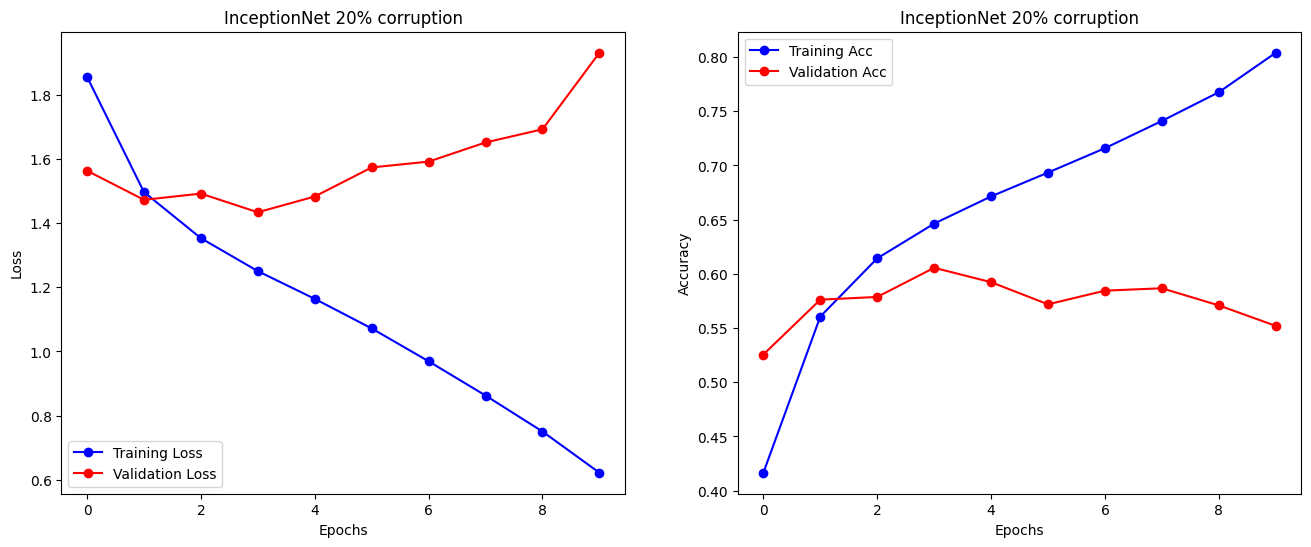

In [30]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 20% corruption")

In [31]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_20.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.6056
Confusion Matrix:
 [[675  28  72  28  30  22  21  28  62  30]
 [ 48 702  38  18  36  19  35  18  33  53]
 [ 84  33 594  47  91  29  43  24  15  29]
 [ 63  26 110 482  88  87  53  39  41  44]
 [ 47  20  96  52 606  26  55  33  19  32]
 [ 32  25 109 151  76 474  35  43  20  25]
 [ 36  22 107  54  53  24 655  21  29  17]
 [ 43  25  94  51 119  46  21 522  20  30]
 [121  34  53  23  25  18  24  15 646  38]
 [ 49  66  41  22  31  18  30  22  41 700]]


In [32]:
final_dict[20] = {}
final_dict[20]["train_losses"] = train_losses
final_dict[20]["valid_losses"] = valid_losses
final_dict[20]["train_accs"] = train_accs
final_dict[20]["validation_accs"] = validation_accs
final_dict[20]["best_test_acc"]  = accuracy_score(testy, pred)


# Test for corruption level 0.4

In [34]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.4)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Trainset:  Dataset CIFAR10Corrupted
    Number of datapoints: 50000
    Root location: ./CIFAR
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified


In [35]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [36]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_40")

Batch 0 Loss: 2.352890968322754
Batch 200 Loss: 3.361978054046631
Batch 400 Loss: 2.3051297664642334
Batch 600 Loss: 2.3279671669006348
Batch 800 Loss: 2.087313175201416
Batch 1000 Loss: 2.0934205055236816
Batch 1200 Loss: 1.894521951675415
Batch 1400 Loss: 1.995489478111267
[Epoch 0] Train Loss: 2.1412411807632448 Vaidation Loss: 1.9822388381958007 Train Acc: 0.29888 Validation Acc: 0.3648
Batch 0 Loss: 1.7877618074417114
Batch 200 Loss: 1.83110773563385
Batch 400 Loss: 2.096158981323242
Batch 600 Loss: 1.8158968687057495
Batch 800 Loss: 2.03588604927063
Batch 1000 Loss: 1.8881343603134155
Batch 1200 Loss: 1.7457077503204346
Batch 1400 Loss: 2.0094480514526367
[Epoch 1] Train Loss: 1.8925280896759034 Vaidation Loss: 1.8924200778961182 Train Acc: 0.41068 Validation Acc: 0.4262
Batch 0 Loss: 1.7013286352157593
Batch 200 Loss: 1.9716079235076904
Batch 400 Loss: 1.7261285781860352
Batch 600 Loss: 2.008136749267578
Batch 800 Loss: 1.442369818687439
Batch 1000 Loss: 1.616652011871338
Batch 

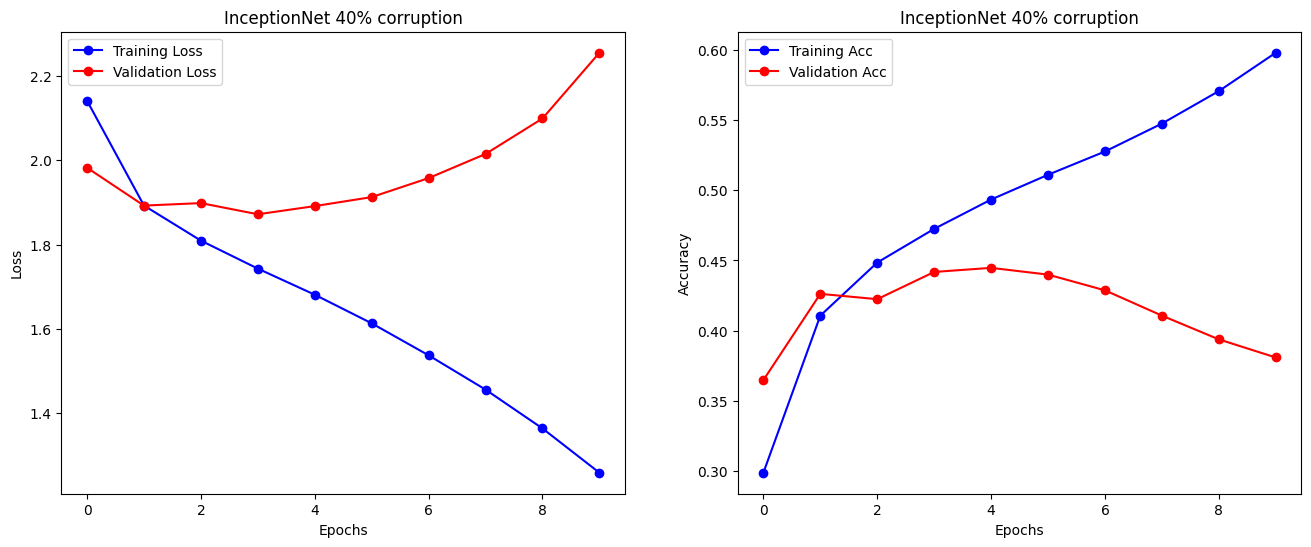

In [37]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 40% corruption")

In [38]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_40.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.4447
Confusion Matrix:
 [[405  64  47 115  83  44  47  41 134  40]
 [ 32 559  32  70  63  37  47  34  82  53]
 [ 60  55 306 135 147  65  77  50  66  33]
 [ 41  56  54 487 105  92  59  48  50  41]
 [ 43  45  56 108 479  33  81  52  64  30]
 [ 32  41  43 219  99 355  53  52  62  25]
 [ 24  39  38 126 108  44 510  38  56  29]
 [ 28  43  48 137 122  76  46 392  50  43]
 [ 50  56  35  74  60  28  44  50 537  37]
 [ 33 117  32 132  62  48  47  39  77 417]]


In [39]:
final_dict[40] = {}
final_dict[40]["train_losses"] = train_losses
final_dict[40]["valid_losses"] = valid_losses
final_dict[40]["train_accs"] = train_accs
final_dict[40]["validation_accs"] = validation_accs
final_dict[40]["best_test_acc"]  = accuracy_score(testy, pred)


# Test for corruption level 0.6

In [41]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.6)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Files already downloaded and verified
Trainset:  Dataset CIFAR10Corrupted
    Number of datapoints: 50000
    Root location: ./CIFAR
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified


In [42]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [43]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_60")

Batch 0 Loss: 2.44460391998291
Batch 200 Loss: 2.3103833198547363
Batch 400 Loss: 2.4225046634674072
Batch 600 Loss: 2.4951560497283936
Batch 800 Loss: 2.2636070251464844
Batch 1000 Loss: 2.159487247467041
Batch 1200 Loss: 2.1755905151367188
Batch 1400 Loss: 2.446270227432251
[Epoch 0] Train Loss: 2.3325680409240723 Vaidation Loss: 2.222420440673828 Train Acc: 0.19442 Validation Acc: 0.2301
Batch 0 Loss: 2.1376354694366455
Batch 200 Loss: 1.9841467142105103
Batch 400 Loss: 2.170100450515747
Batch 600 Loss: 2.1144306659698486
Batch 800 Loss: 2.2528607845306396
Batch 1000 Loss: 2.3091495037078857
Batch 1200 Loss: 2.0473363399505615
Batch 1400 Loss: 2.0359556674957275
[Epoch 1] Train Loss: 2.1609035118865965 Vaidation Loss: 2.1690351596832276 Train Acc: 0.26638 Validation Acc: 0.2647
Batch 0 Loss: 2.2862744331359863
Batch 200 Loss: 2.145642042160034
Batch 400 Loss: 2.1277661323547363
Batch 600 Loss: 2.056800127029419
Batch 800 Loss: 2.0282368659973145
Batch 1000 Loss: 2.461806058883667
Ba

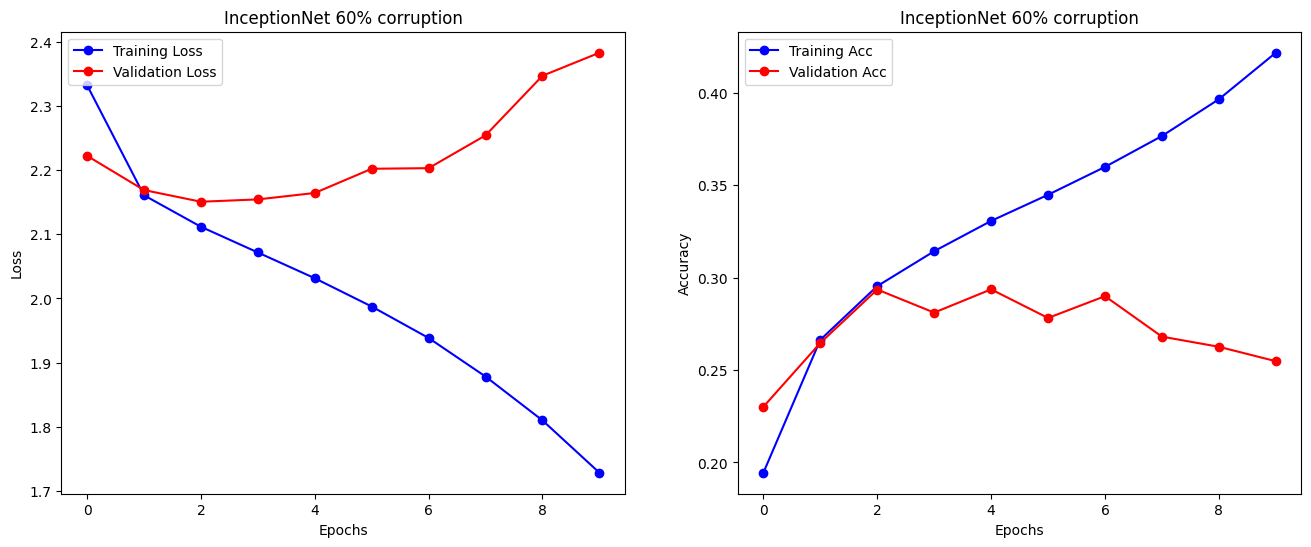

In [44]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 60% corruption")

In [45]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_60.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.2937
Confusion Matrix:
 [[308  41  43  83 102  65  56  92 167  70]
 [101 284  28  82 121  56  61  79 117  97]
 [100  47 137 100 175  79  61 105 114  68]
 [ 79  39  40 267 116 127  70  98 110  75]
 [ 66  37  29 103 316  87  73 109 104  55]
 [ 76  43  31 132 135 240  48 101  97  71]
 [ 75  49  37 116 108  66 311 100  92  58]
 [ 74  48  41  81 124  85  64 357  87  48]
 [ 90  45  31  63  81  60  55  75 406  74]
 [ 83  54  33  86 105  59  45  91 119 311]]


In [46]:
final_dict[60] = {}
final_dict[60]["train_losses"] = train_losses
final_dict[60]["valid_losses"] = valid_losses
final_dict[60]["train_accs"] = train_accs
final_dict[60]["validation_accs"] = validation_accs
final_dict[60]["best_test_acc"]  = accuracy_score(testy, pred)


# Test for corruption level 0.8

In [47]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.8)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Trainset:  Dataset CIFAR10Corrupted
    Number of datapoints: 50000
    Root location: ./CIFAR
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified
cuda:0


In [48]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [49]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_80")

Batch 0 Loss: 2.402270793914795
Batch 200 Loss: 2.437612771987915
Batch 400 Loss: 2.6289663314819336
Batch 600 Loss: 2.464240312576294
Batch 800 Loss: 2.3304216861724854
Batch 1000 Loss: 2.238224744796753
Batch 1200 Loss: 2.266515016555786
Batch 1400 Loss: 2.2748055458068848
[Epoch 0] Train Loss: 2.4249259765625 Vaidation Loss: 2.2995509311676026 Train Acc: 0.12314 Validation Acc: 0.1406
Batch 0 Loss: 2.4102237224578857
Batch 200 Loss: 2.2784035205841064
Batch 400 Loss: 2.282799482345581
Batch 600 Loss: 2.200176239013672
Batch 800 Loss: 2.2617404460906982
Batch 1000 Loss: 2.2641754150390625
Batch 1200 Loss: 2.267029047012329
Batch 1400 Loss: 2.2778799533843994
[Epoch 1] Train Loss: 2.2834777737426757 Vaidation Loss: 2.3042289581298827 Train Acc: 0.15676 Validation Acc: 0.1424
Batch 0 Loss: 2.2761504650115967
Batch 200 Loss: 2.2603583335876465
Batch 400 Loss: 2.294879913330078
Batch 600 Loss: 2.309304714202881
Batch 800 Loss: 2.3311471939086914
Batch 1000 Loss: 2.217954397201538
Batch 1

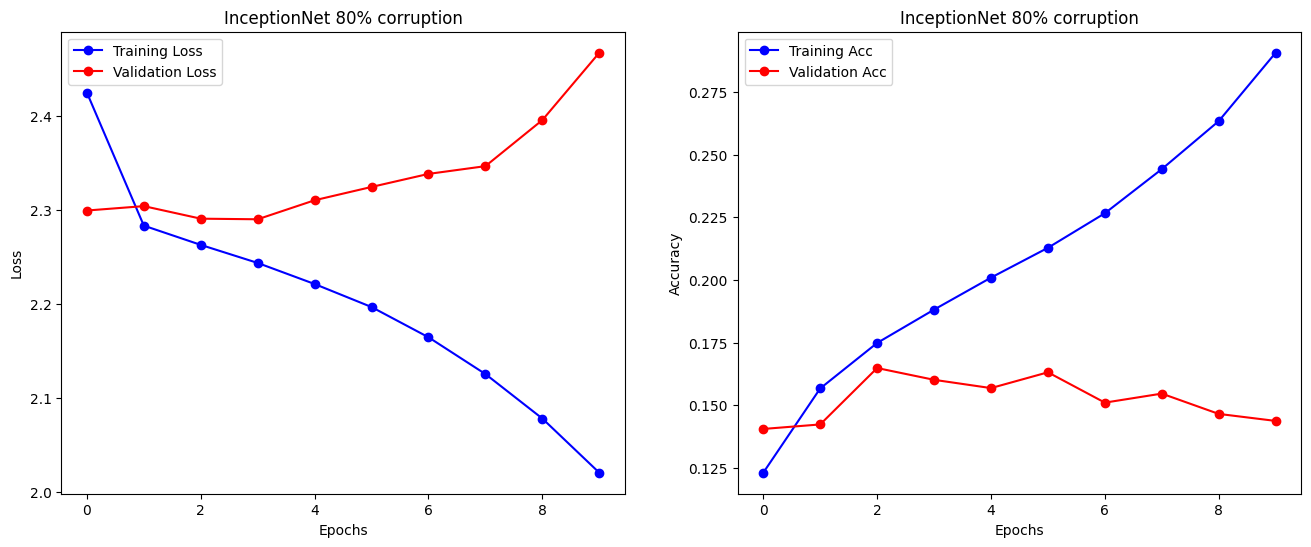

In [50]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 80% corruption")

In [52]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_80.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.1649
Confusion Matrix:
 [[139 186  26   7  30  28 131 248  57 159]
 [ 57 291  21  14  18  24 129 260  39 176]
 [ 65 164  33  23  35  33 153 315  50 116]
 [ 59 179  22  36  17  42 164 317  36 148]
 [ 41 146  23  18  49  23 172 332  39 111]
 [ 57 187  32  21  23  51 131 327  35 117]
 [ 54 145  16  17  23  24 292 249  48 147]
 [ 49 150  19  12  29  21 119 394  53 152]
 [ 58 199  17  16  23  21 143 251  99 160]
 [ 48 197  18  13  15  24 121 268  49 265]]


In [53]:
final_dict[80] = {}
final_dict[80]["train_losses"] = train_losses
final_dict[80]["valid_losses"] = valid_losses
final_dict[80]["train_accs"] = train_accs
final_dict[80]["validation_accs"] = validation_accs
final_dict[80]["best_test_acc"]  = accuracy_score(testy, pred)


# Test for corruption level 1: Random labels

In [57]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(1.0)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Trainset:  Dataset CIFAR10Corrupted
    Number of datapoints: 50000
    Root location: ./CIFAR
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified


In [58]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [59]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_100")

Batch 0 Loss: 2.355552911758423
Batch 200 Loss: 2.7187018394470215
Batch 400 Loss: 2.3800909519195557
Batch 600 Loss: 2.301180124282837
Batch 800 Loss: 2.4804556369781494
Batch 1000 Loss: 2.3162543773651123
Batch 1200 Loss: 2.3253402709960938
Batch 1400 Loss: 2.3504583835601807
[Epoch 0] Train Loss: 2.4046687380981444 Vaidation Loss: 2.3170408630371093 Train Acc: 0.10068 Validation Acc: 0.097
Batch 0 Loss: 2.346688985824585
Batch 200 Loss: 2.317760705947876
Batch 400 Loss: 2.28072190284729
Batch 600 Loss: 2.3688511848449707
Batch 800 Loss: 2.280637741088867
Batch 1000 Loss: 2.3295681476593018
Batch 1200 Loss: 2.3025870323181152
Batch 1400 Loss: 2.3230066299438477
[Epoch 1] Train Loss: 2.3168390643310546 Vaidation Loss: 2.318457841873169 Train Acc: 0.10496 Validation Acc: 0.1064
Batch 0 Loss: 2.304969549179077
Batch 200 Loss: 2.395609140396118
Batch 400 Loss: 2.2614033222198486
Batch 600 Loss: 2.3527779579162598
Batch 800 Loss: 2.2727255821228027
Batch 1000 Loss: 2.3236680030822754
Batc

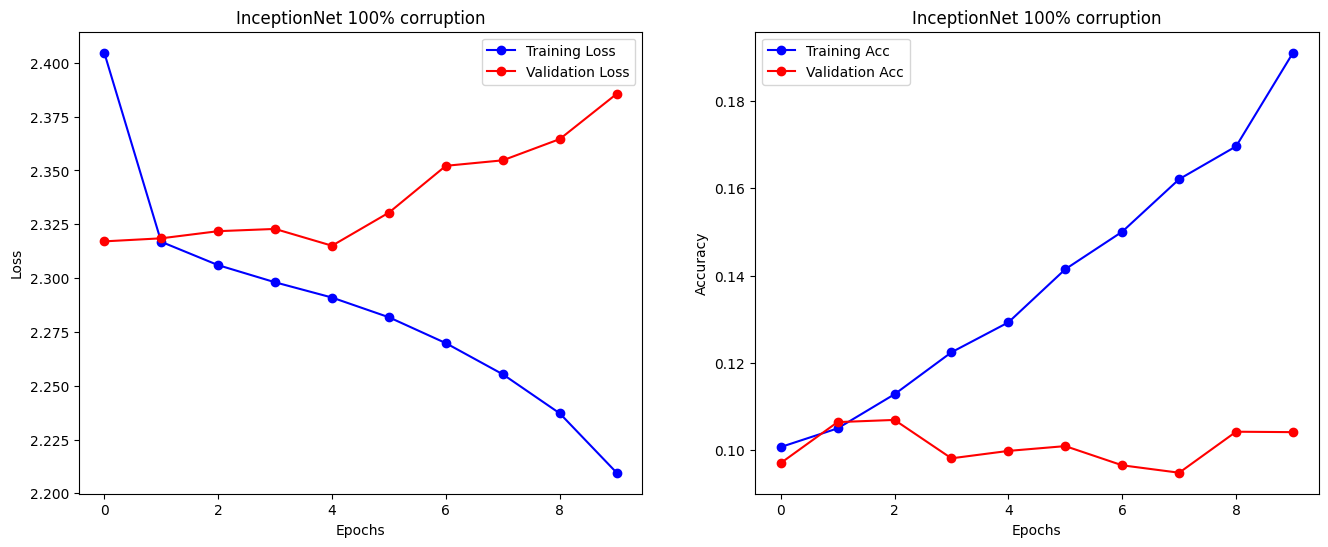

In [60]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 100% corruption")

In [61]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_100.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.1069
Confusion Matrix:
 [[  0 611 117   1  11  11  10 109   1 143]
 [  1 667 105   1   7   7   7 108   0 137]
 [  3 611  98   1  15   5  11 102   1 144]
 [  0 624 102   0   8   9   2 127   2 138]
 [  1 592  84   0  12   5  10 123   1 117]
 [  2 649 109   0   8   5  13 108   1 122]
 [  0 628  99   0   7   3  10 120   0 130]
 [  3 590 105   0   8   7  18 114   1 147]
 [  0 598  79   0   9  13   8 120   3 143]
 [  2 630  98   1  12   7   6 102   0 160]]


In [62]:
final_dict[100] = {}
final_dict[100]["train_losses"] = train_losses
final_dict[100]["valid_losses"] = valid_losses
final_dict[100]["train_accs"] = train_accs
final_dict[100]["validation_accs"] = validation_accs
final_dict[100]["best_test_acc"]  = accuracy_score(testy, pred)


# End tests

In [63]:
with open('final.pickle', 'wb') as f:
    pickle.dump(final_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
!curl bashupload.com -T final.pickle



Uploaded 1 file, 2 489 bytes

wget http://bashupload.com/ZwScX/final.pickle




In [65]:
!zip inception.zip *.*
!curl bashupload.com -T inception.zip

  adding: final.pickle (deflated 18%)
  adding: InceptionNet_corr_0.pth (deflated 8%)
  adding: InceptionNet_corr_100.pth (deflated 8%)
  adding: InceptionNet_corr_20.pth (deflated 8%)
  adding: InceptionNet_corr_40.pth (deflated 8%)
  adding: InceptionNet_corr_60.pth (deflated 8%)
  adding: InceptionNet_corr_80.pth (deflated 8%)
  adding: Label_Corruption_Analysis.ipynb (deflated 28%)
  adding: Label_Corruption_Inception.ipynb (deflated 28%)
  adding: Label_Corruption_MLP.ipynb (deflated 40%)
  adding: Label_Corruption_Wide_ResNet.ipynb (deflated 40%)


Uploaded 1 file, 41 929 088 bytes

wget http://bashupload.com/wJtHx/inception.zip


